# Loading libraries

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]='2'
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

from transformers import BertTokenizer
from datasets import Dataset
from datasets import load_metric
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import TrainerCallback
import warnings
warnings.filterwarnings('ignore', message="A parameter name that contains `beta` will be renamed internally to `bias`")


In [2]:
data=pd.read_csv("/kaggle/input/resume-categorization/Resume/Resume.csv")
data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# Preprocessing

In [3]:
data.isnull().sum()

ID             0
Resume_str     0
Resume_html    0
Category       0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [5]:
data['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

In [6]:
data['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [7]:
df=data.copy()

In [8]:
df.drop(columns=["Resume_html"],inplace=True)
df.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


In [9]:
# Encode the labels
df['Category'] = df['Category'].astype('category')
df['label'] = df['Category'].cat.codes

In [10]:
df.head(2)

,ID,Resume_str,Category,label
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,19
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,19


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


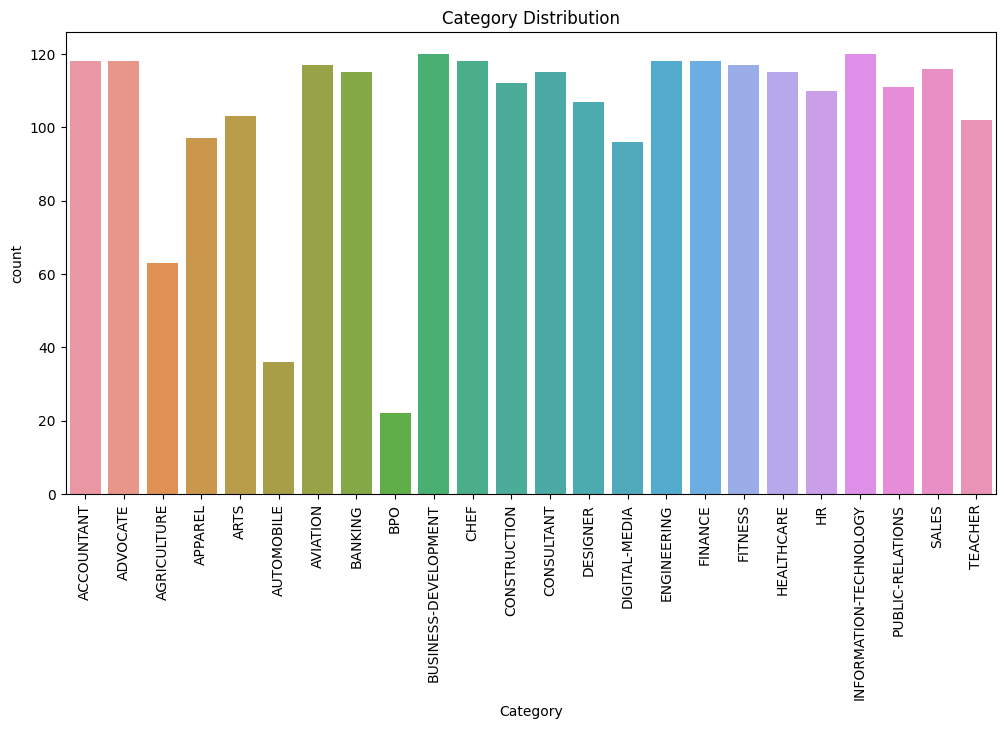

In [11]:
# Visualize the distribution of categories
plt.figure(figsize=(12, 6))
sns.countplot(x=df['Category'])
plt.xticks(rotation=90)
plt.title('Category Distribution')
plt.show()

In [12]:
# Split dataset
train, temp = train_test_split(df, test_size=0.3, stratify=df['label'])
val, test = train_test_split(temp, test_size=0.3, stratify=temp['label'])

In [13]:
print(train.shape,val.shape,test.shape)

(1738, 4) (522, 4) (224, 4)


In [14]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [15]:
# Define a function to tokenize the text
def tokenize_function(examples):
    return tokenizer(examples['Resume_str'], padding='max_length', truncation=True)

In [16]:
# Convert DataFrames to Hugging Face Datasets
train_df = Dataset.from_pandas(train)
val_df = Dataset.from_pandas(val)
test_df = Dataset.from_pandas(test)

In [17]:
# Tokenize datasets
train_df = train_df.map(tokenize_function, batched=True)
val_df= val_df.map(tokenize_function, batched=True)
test_df = test_df.map(tokenize_function, batched=True)

Map:   0%|          | 0/1738 [00:00<?, ? examples/s]

Map:   0%|          | 0/522 [00:00<?, ? examples/s]

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

In [18]:
# Set the input columns 
train_df.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_df.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_df.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Model and Training

In [19]:
# Load BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['label'].unique()))

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [20]:
#call back to save full model
class CustomCallback(TrainerCallback):
    def on_train_end(self, args, state, control, model=None, tokenizer=None, **kwargs):
        # Save the entire model as a single file
        torch.save(model,'/kaggle/working/model.pt')


# Define the metrics for evaluation
def compute_metrics(p):
    pred, labels = p
    if isinstance(pred, np.ndarray):
        pred = torch.tensor(pred)
    pred = torch.argmax(pred, axis=1)
    acc = accuracy_score(labels, pred)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted')
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_steps=500,                  
    save_steps=1000, 
    save_total_limit=2
)

# Initialize the Hugging Face Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_df,
    eval_dataset=val_df,
    compute_metrics=compute_metrics,
    callbacks=[CustomCallback()]
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [21]:
# Train 
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: likhon (likhon-ai). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,3.125100,3.026137,0.227969,0.148370,0.220292,0.227969
2,2.424600,2.349755,0.538314,0.489293,0.550942,0.538314
3,1.972100,1.776585,0.747126,0.714622,0.766512,0.747126
4,1.516700,1.509501,0.770115,0.737895,0.780222,0.770115
5,1.456700,1.420565,0.789272,0.763107,0.790424,0.789272


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision

TrainOutput(global_step=275, training_loss=2.2004550170898436, metrics={'train_runtime': 511.4986, 'train_samples_per_second': 16.989, 'train_steps_per_second': 0.538, 'total_flos': 2286886708592640.0, 'train_loss': 2.2004550170898436, 'epoch': 5.0})

# Evaluation

In [22]:
# evaluate on test set
trainer.evaluate(test_df)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.3999806642532349,
 'eval_accuracy': 0.78125,
 'eval_f1': 0.7451118823666741,
 'eval_precision': 0.7516488194928321,
 'eval_recall': 0.78125,
 'eval_runtime': 3.7111,
 'eval_samples_per_second': 60.36,
 'eval_steps_per_second': 1.886,
 'epoch': 5.0}

# Confusion matrix for test set

In [23]:
# predictions 
predictions = trainer.predict(test_df)
# Extract labels
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# confusion matrix
cm = confusion_matrix(labels, preds)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


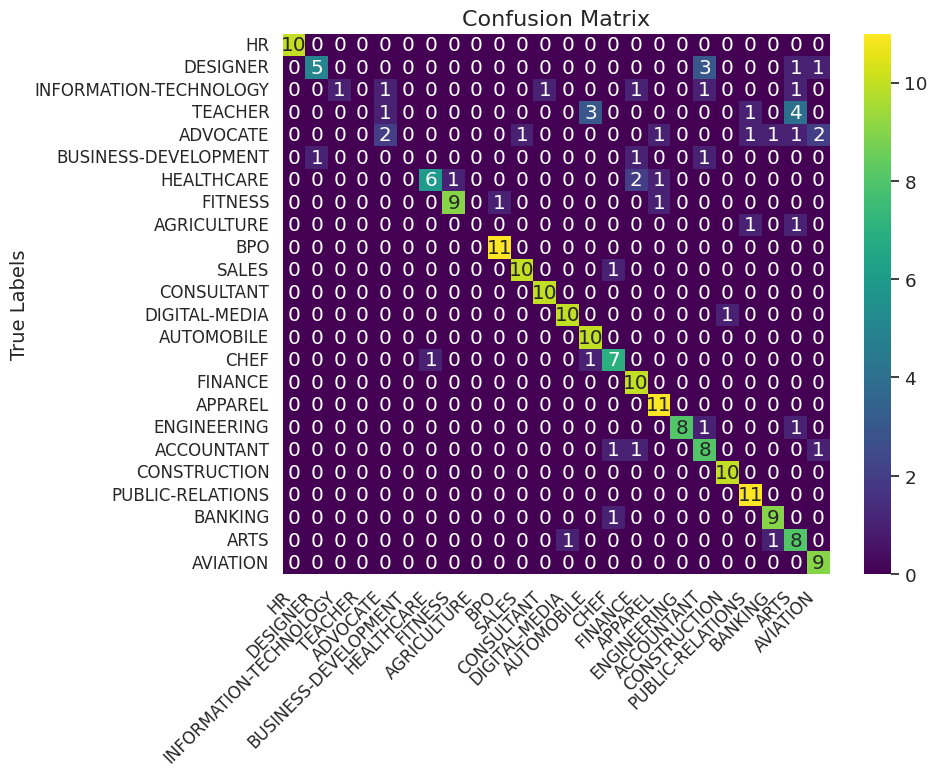

In [24]:
category_labels=['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION']


plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  

# Plot confusion matrix with annotations
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=True, xticklabels=category_labels, yticklabels=category_labels)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

In [26]:
!pip install PyPDF2

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.3 MB/s eta 0:00:00ta 0:00:01


In [27]:
# Load the trained model and tokenizer
model_path = '/kaggle/working/results/checkpoint-275'  
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Function to predict resume category
def predict_resume_category(resume_text):
    inputs = tokenizer(resume_text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()
    return predicted_class_id

# Define category labels
category_labels = df['Category'].cat.categories.tolist()

# Script to categorize resumes
def categorize_resumes(directory):
    resume_files = [f for f in os.listdir(directory) if f.endswith('.pdf')]  
    categorized_data = []
    
    for resume in resume_files:
        resume_path = os.path.join(directory, resume)
        resume_text = extract_text_from_pdf(resume_path)  
        
        predicted_category = predict_resume_category(resume_text)
        category_name = category_labels[predicted_category]
        
        # writable directory for categorized resumes
        writable_dir = os.path.join('/kaggle/working/categorized_resumes', category_name)
        os.makedirs(writable_dir, exist_ok=True)
        
        # resume to the predicted category folder 
        shutil.copy(resume_path, os.path.join(writable_dir, resume))
        
        # Append to categorized data for CSV
        categorized_data.append({"filename": resume, "category": category_name})
    
    # Save resulT
    categorized_resumes_df = pd.DataFrame(categorized_data)
    categorized_resumes_df.to_csv('/kaggle/working/categorized_resumes.csv', index=False)

# PDF text extraction 
def extract_text_from_pdf(pdf_path):
    from PyPDF2 import PdfReader
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    return text


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [28]:
# Usage: Pass the directory containing resumes
categorize_resumes('/kaggle/input/resume-categorization/data/data/ACCOUNTANT')

# Glimpse to the output csv

In [29]:
output_csv=pd.read_csv("/kaggle/working/categorized_resumes.csv")

In [30]:
output_csv.head()

,filename,category
0,27558837.pdf,ACCOUNTANT
1,25547145.pdf,ACCOUNTANT
2,28298773.pdf,ACCOUNTANT
3,22465498.pdf,ACCOUNTANT
4,15363277.pdf,ACCOUNTANT


In [31]:
output_csv["category"].value_counts()

category
ACCOUNTANT      116
FINANCE           1
CONSTRUCTION      1
Name: count, dtype: int64

In [32]:
print("Notebook Completed")

Notebook Completed
